# RAPIDS cuDF

!!! tip "Run Jupyter Notebook"
    You can run the code for this section in this [jupyter notebook link](https://github.com/ritchieng/deep-learning-wizard/blob/master/docs/machine_learning/gpu/rapids_cudf.ipynb) on Google Colab. Simply copy the notebook into your Google Drive and run with Google Colab.

## Environment Setup

#### Python Version

In [0]:
# Check Python Version
!python --version

Python 3.6.7


#### Ubuntu Version

In [0]:
# Check Ubuntu Version
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.2 LTS
Release:	18.04
Codename:	bionic


#### Check CUDA Version

In [0]:
# Check CUDA/cuDNN Version
!nvcc -V && which nvcc

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
/usr/local/cuda/bin/nvcc


#### Check GPU Version

In [0]:
# Check GPU
!nvidia-smi

Sun May 26 13:30:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Check GPU if You've Right Version (T4)
Many thanks to NVIDIA team for this snippet of code to automatically set up everything.

In [0]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if device_name != b'Tesla T4':
  raise Exception("""
    Unfortunately this instance does not have a T4 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4. Resetting the instance.

    If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)
else:
  print('Woo! You got the right kind of GPU!')

Woo! You got the right kind of GPU!


In [0]:
# intall miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# install RAPIDS packages
!conda install -q -y --prefix /usr/local -c conda-forge \
  -c rapidsai-nightly/label/cuda10.0 -c nvidia/label/cuda10.0 \
  cudf cuml

# set environment vars
import sys, os, shutil
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# copy .so files to current working dir
for fn in ['libcudf.so', 'librmm.so']:
  shutil.copy('/usr/local/lib/'+fn, os.getcwd())

##Critical imports

In [0]:
# Critical imports
import nvstrings, nvcategory, cudf
import cuml
import os
import numpy as np
import pandas as pd

ModuleNotFoundError: ignored

# Eigen-portfolio construction using Principal Component Analysis (PCA)

## Implementing PCA using Rapid's CuML and S&P 500 Index stock data

[To add: Intro] 

We look will look at model-free factor analysis using PCA. By model-free we mean that we do not rely on any factors such as value or momentum to decompose portfolio returns, but instead using Principal Component Analysis (PCA) to deduce structure of portfolio returns.

We will work with S&P 500 index stock data. 

In [0]:
import os
import os.path
import numpy as np
import datetime
try:
    import pandas as pd
    print("  pandas: %s"% pd.__version__)
except:
    print("Missing pandas package")

  pandas: 0.24.2


In [0]:
# load dataset
url = 'https://raw.githubusercontent.com/titmy/eigen-portfolio-construction/master/spx_holdings_and_spx_closeprice.csv'
asset_prices = pd.read_csv(url,
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()

In [0]:
n_stocks_show = 12
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250


In [0]:
print('Last column contains SPX index prices:')
asset_prices.iloc[:, -10:].head()

Last column contains SPX index prices:


,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


## Part 1 (Asset Returns Calculation)

###Before we start building the PCA model with the dataset, we want to account for stationarity in stock prices. To address this problem, we calculate for percent returns, also known as simple returns using asset_prices. We will assign the result to variable asset_returns. 


###We now compute stock returns and normalize stock returns data by subtracting the mean and dividing by standard diviation. This normalization is necessary for PCA to perform well. This is because PCA calculates a new projection on the data set, and the new axis are based on the standard deviation of the variables. Thus, a variable with a high standard deviation will have a higher weight for the calculation of axis than a variable with a low standard deviation. When we normalize the data, all variables have the same standard deviation, thus all variables have the same weight and the PCA calculates relevant axis in relation to others

In [0]:
asset_returns = pd.DataFrame(data=np.zeros(shape=(len(asset_prices.index), asset_prices.shape[1])), 
                             columns=asset_prices.columns.values,
                             index=asset_prices.index)

In [0]:
prev_row = 0
for index, row in asset_prices.iterrows():
    if index == 0:
        prev_row = row
    else:
        dif = row - prev_row
        #print(dif)
        returns = dif / prev_row
        asset_returns.loc[index] = returns
        prev_row = row

asset_returns = asset_returns.drop(asset_returns.index[0], axis=0)
normed_returns = asset_returns
asset_returns.head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AGN,AIG,AIV,AKAM,AKS,ALL,AMAT,AMD,AMGN,AMT,AMZN,AN,ANDV,ANF,AON,APA,APC,APD,APH,APOL,ARG,ATGE,AVB,AVY,AXP,AZO,...,9876566D,9876641D,ATI,AVP,BBBY,BF/B,BIG,BMS,BRK/B,CSC,CVC,DD,DOW,EMC,HSH,ITT,JCP,LXK,MDP,NYT,ODP,PBI,PLL,R,RDC,RRD,RSHCQ,SIAL,SLM,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-28,-0.005480,-0.014185,-0.076134,0.000000,0.034482,-0.081758,-0.005857,-0.015628,-0.024907,-0.049994,-0.018975,-0.016760,0.006590,0.019724,0.014160,-0.030879,0.000000,-0.039351,0.017341,-0.016173,-0.042435,-0.045688,-0.027487,-0.014645,-0.078431,0.016124,-0.031413,0.011364,-0.021295,-0.006694,0.003817,-0.034413,-0.046907,-0.005836,0.000000,0.000000,-0.012431,-0.028311,-0.028768,-0.030074,...,-0.026605,-0.055119,-0.014575,-0.044695,-0.004513,-0.007904,-0.075001,0.008064,-0.021226,-0.003487,-0.059620,-0.036585,-0.036217,-0.054397,-0.013565,-0.011792,-0.051612,0.023020,-0.025814,-0.014626,-0.012342,-0.019050,-0.027467,-0.022601,-0.034384,-0.014250,-0.038462,-0.047101,-0.032950,-0.057535,-0.025001,-0.048443,0.038465,-0.014428,-0.083789,-0.019660,0.021858,-0.028505,-0.014005,-0.027457
2000-01-31,-0.027548,0.002698,0.020912,-0.033352,0.021570,-0.043431,-0.020942,-0.005292,-0.030651,-0.010131,0.007737,0.015152,0.049100,0.034229,0.001565,0.023284,0.003309,-0.077528,-0.079545,0.016438,0.057803,0.021277,0.067015,-0.051252,0.046605,-0.039685,-0.048657,-0.039326,0.000000,-0.016831,-0.001898,-0.006291,-0.010035,0.014664,-0.060606,0.042403,-0.007201,0.018797,0.041075,0.002367,...,0.020499,0.122223,-0.011832,-0.007790,-0.013608,0.018207,0.027030,0.008000,-0.008434,0.029412,-0.019263,-0.004221,0.015249,0.050182,0.013751,0.007947,0.068026,-0.001985,-0.010602,-0.013495,0.000000,0.087380,-0.003374,0.020228,0.077148,0.014456,0.009032,0.019011,0.011349,0.107560,0.017957,0.047273,0.030302,-0.012189,0.029822,0.013675,-0.026739,-0.026896,0.008116,0.025218
2000-02-01,0.072710,0.034978,-0.033735,0.031045,0.009593,0.014761,0.048128,0.021281,0.015810,0.036816,0.000000,0.005597,0.007800,0.020144,0.026344,-0.019162,0.001653,-0.040391,-0.018519,-0.005391,0.023679,0.015628,0.025515,0.080139,0.044530,-0.066112,0.000000,-0.026316,0.016928,0.039384,0.043806,0.033759,-0.006459,0.118498,-0.040323,0.010169,0.000000,-0.010148,0.025797,0.002400,...,0.017854,0.032177,-0.005987,0.005888,0.131037,-0.008951,0.017543,0.001987,0.017618,-0.029253,0.000819,0.014832,0.028969,-0.024475,-0.006779,-0.003930,-0.041399,0.017242,-0.021427,0.015046,0.012496,0.011478,-0.013563,-0.011326,0.000000,0.028485,-0.058822,0.042913,0.043334,-0.010499,-0.022685,-0.038195,0.019607,0.007406,0.083976,0.007196,-0.002746,0.000000,0.028171,0.010628
2000-02-02,0.077464,0.033795,-0.014356,0.010037,0.005709,0.097310,-0.017857,-0.020837,-0.054475,0.005920,0.000000,-0.001855,-0.017801,0.001408,0.034755,-0.000611,-0.001650,-0.022745,0.006289,0.010840,0.023576,-0.013675,-0.024880,0.012903,0.029657,-0.070792,-0.005673,0.015015,0.038004,-0.001650,-0.051095,-0.008166,0.021330,-0.018084,0.008403,0.003356,0.000000,-0.006524,-0.028476,-0.019002,...,-0.014254,0.002397,-0.060245,0.005863,0.002032,0.001137,0.021553,-0.005938,-0.020896,-0.036439,0.033526,0.014612,-0.039623,0.032258,-0.003416,-0.001985,-0.023257,0.053454,0.005473,-0.010779,0.006181,-0.037829,0.010311,0.011456,-0.011018,0.008310,0.006793,-0.037567,-0.039998,0.050399,-0.012887,-0.018051,-0.006410,0.002444,0.023152,0.019643,0.033057,-0.002508,-0.015653,-0.000114
2000-02-03,0.016340,-0.031014,0.045537,-0.006617,0.005670,0.126402,0.098701,0.000000,0.067217,0.035288,0.011516,0.033457,0.013395,0.012678,0.024806,-0.009774,0.000000,0.050294,-0.037500,-0.010724,0.032595,0.081453,0.004899,0.019108,0.212420,-0.047622,-0.005723,-0.020710,0.000000,0.004952,-0.021151,0.012346,0.004530,0.005258,0.016667,0.003344,-0.003627,-0.008443,-0.007995,0.029055,...,0.000000,0.071773,-0.032046,0.003880,0.002028,0.021388,-0.004221,0.011947,0.018293,0.025453,-0.015032,-0.017489,-0.001088,0.018520,0.017125,-0.001989,-0.013605,0.049

In [0]:
normed_returns = (asset_returns - asset_returns.mean()) / asset_returns.std()
normed_returns.head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AGN,AIG,AIV,AKAM,AKS,ALL,AMAT,AMD,AMGN,AMT,AMZN,AN,ANDV,ANF,AON,APA,APC,APD,APH,APOL,ARG,ATGE,AVB,AVY,AXP,AZO,...,9876566D,9876641D,ATI,AVP,BBBY,BF/B,BIG,BMS,BRK/B,CSC,CVC,DD,DOW,EMC,HSH,ITT,JCP,LXK,MDP,NYT,ODP,PBI,PLL,R,RDC,RRD,RSHCQ,SIAL,SLM,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-28,-0.190054,-0.513710,-2.714709,-0.049779,2.182933,-2.684131,-0.212461,-0.766996,-1.540731,-1.803947,-1.372991,-0.994169,0.161362,0.729804,0.634856,-0.721319,-0.013029,-0.807978,0.399231,-0.758933,-1.434447,-1.127839,-1.293853,-0.448029,-2.139734,0.589498,-0.878264,0.314286,-1.080602,-0.313679,0.118193,-1.868678,-1.872752,-0.226084,-0.041891,-0.021361,-0.604587,-1.430874,-1.166797,-1.655943,...,-1.470792,-2.667202,-0.444949,-2.046917,-0.208779,-0.587150,-2.685122,0.455900,-1.423147,-0.149303,-2.043780,-1.969971,-1.536587,-1.786760,-0.833218,-0.676792,-1.727559,0.805828,-1.359516,-0.568986,-0.325843,-1.004339,-1.409672,-1.000541,-1.194180,-0.684176,-1.189341,-2.563051,-1.022915,-2.263928,-1.280756,-1.690468,1.853435,-1.032223,-2.354104,-0.735242,0.619711,-0.873112,-0.652514,-2.098603
2000-01-31,-0.898232,0.096888,0.688156,-1.757230,1.355644,-1.438899,-0.720771,-0.279098,-1.891884,-0.391433,0.547298,0.871919,1.279743,1.285509,0.043463,0.542406,0.110677,-1.578480,-1.931862,0.727049,1.934495,0.511700,3.089411,-1.510241,1.220422,-1.570581,-1.340650,-1.178609,-0.026452,-0.740179,-0.104367,-0.365316,-0.430671,0.481221,-2.441573,1.420915,-0.361751,0.941135,1.618591,0.073137,...,1.074986,5.829573,-0.365672,-0.369638,-0.565284,1.199225,0.938210,0.452002,-0.583879,1.185313,-0.668547,-0.242512,0.619663,1.632467,0.801256,0.382019,2.254445,-0.075617,-0.569375,-0.525164,-0.014835,4.556592,-0.203873,0.838851,2.616015,0.658475,0.289344,0.982405,0.319906,4.189346,0.845295,1.631244,1.457667,-0.877804,0.828987,0.498547,-0.789312,-0.824893,0.333856,1.903871
2000-02-01,2.319164,1.264327,-1.227995,1.539597,0.588289,0.451774,1.606541,0.975244,0.948126,1.272129,-0.008894,0.313197,0.193209,0.745874,1.206912,-0.447938,0.048759,-0.828978,-0.463552,-0.267643,0.787615,0.373396,1.164518,2.302276,1.164650,-2.593399,-0.035912,-0.795440,0.811495,1.624857,1.675543,1.775699,-0.290829,4.063868,-1.638454,0.324540,-0.027361,-0.516315,1.009315,0.074870,...,0.932012,1.515312,-0.196702,0.252030,5.104371,-0.658785,0.601316,0.088663,1.125284,-1.194540,0.015785,0.774450,1.194481,-0.808459,-0.427193,-0.255078,-1.387627,0.602151,-1.131621,0.580966,0.300059,0.590764,-0.713834,-0.516304,-0.019541,1.314692,-1.823268,2.264247,1.289501,-0.425362,-1.166142,-1.334823,0.939094,0.473545,2.346267,0.258770,-0.093661,-0.018944,1.228056,0.795259
2000-02-02,2.471738,1.221529,-0.548494,0.464060,0.339454,3.133764,-0.616815,-1.012898,-3.348109,0.177340,-0.008894,-0.122594,-0.480317,0.028047,1.601860,-0.015104,-0.074715,-0.472839,0.133325,0.471954,0.784133,-0.344049,-1.172953,0.351322,0.764954,-2.774543,-0.188027,0.421825,1.854824,-0.101493,-2.020283,-0.465526,0.795969,-0.648688,0.290838,0.092778,-0.027361,-0.333844,-1.155158,-1.065821,...,-0.803268,0.088518,-1.765127,0.250880,0.047766,0.031363,0.743704,-0.390171,-1.401439,-1.486067,1.130342,0.762711,-1.679290,1.046426,-0.225960,-0.150736,-0.783802,1.878672,0.265568,-0.419912,0.140927,-1.985516,0.481032,0.462099,-0.395932,0.371033,0.219645,-2.051754,-1.236577,1.955012,-0.681225,-0.635746,-0.322437,0.131399,0.642124,0.719436,0.944422,-0.094098,-0.726004,-0.020920
2000-02-03,0.510174,-1.122380,1.551619,-0.388563,0.336944,4.078966,3.310577,-0.029293,4.090396,1.217955,0.818989,1.942390,0.340400,0.459844,1.134683,-0.228905,-0.013029,1.001247,-0.920247,-0.510654,1.087268,1.985037,0.208284,0.531370,5.676422,-1.877769,-0.189385,-0.630341,-0.026452,0.176282,-0.854141,0.631008,0.138940,0.156678,0.618021,0.092397,-0.195769,-0.430472,-0.338333,1.495542,...,-0.032905,3.412415,-0.949983,0.160745,0.047605,1.416816,-0.171579,0.690486,1.169516,1.024739,-0.524354,-0.950722,-0.064809,0.597278,1.003136,-0.15094

###Setting up pandas dataframe 

In [0]:
train_end = datetime.datetime(2012, 3, 26) 

df_train = None
df_test = None
df_raw_train = None
df_raw_test = None

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3055, 419)
Test dataset: (437, 419)


## Part 2 (PCA fitting)

In [0]:
import sklearn as sklearn
print("  sklearn: %s"% sklearn.__version__)
from sklearn.decomposition import PCA
import seaborn as sns

# Removing SPX index from tickers
stock_tickers = normed_returns.columns.values[:-1]

n_tickers = len(stock_tickers)
cov_matrix = pd.DataFrame(data=np.ones(shape=(n_tickers, n_tickers)), columns=stock_tickers)
cov_matrix_raw = cov_matrix


stock_tickers = asset_returns.columns.values[:-1]

# computing PCA on S&P 500 stocks
cov_raw = df_raw_train[stock_tickers].cov()
pca = PCA()
pca.fit(cov_raw)


cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_matrix_raw)}, index=stock_tickers)    
# cumulative variance explained
var_threshold = 0.8
var_explained = np.cumsum(pca.explained_variance_ratio_)
num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

  sklearn: 0.20.3
2 components explain 80.00% of variance


In [0]:
# Computing for normalized returns
cov_matrix = df_train[stock_tickers].cov()
pca.fit(cov_matrix)

cov_df = pd.DataFrame({'Variance': np.diag(cov_matrix)}, index=stock_tickers)    
# cumulative variance explained
var_threshold = 0.8
var_explained = np.cumsum(pca.explained_variance_ratio_)
num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

4 components explain 80.00% of variance


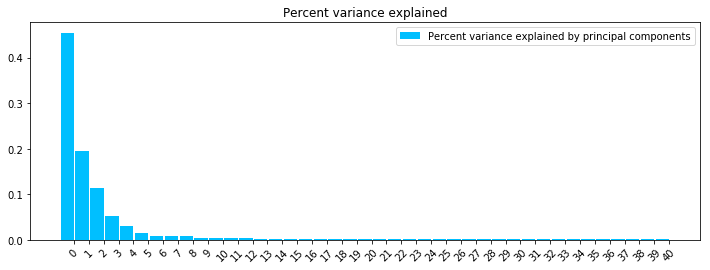

In [0]:
import matplotlib.pyplot as plt

bar_width = 0.9
n_asset = int((1 / 10) * normed_returns.shape[1])
x_indx = np.arange(n_asset)
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
# Eigenvalues are measured as percentage of explained variance.
rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
ax.set_xticks(x_indx + bar_width / 2)
ax.set_xticklabels(list(range(n_asset)), rotation=45)
ax.set_title('Percent variance explained')
ax.legend((rects[0],), ('Percent variance explained by principal components',))

## Part 3 (Eigen-portfolios construction)

We now look a the first two eigen portfolios. We use definition of eigen portfolios as provided by Avellaneda 
http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf 

Following Avellaneda we define eigen portfolio weights as:
$$Q_i^{(j)} = \frac{v_i^{(j)}}{\sigma_i}$$

where $j$ is the index of eigen portfolio and $v_i$ is the i-th element of j-th eigen vector.

In the code the pca.components_ are the Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_. 

We then normalize the portfolio weights so they sum up to one, where positive means a long position and negative value means a short. The weights of the first eigen portfolio will be pc_w

Sum of weights of first eigen-portfolio: 1.00


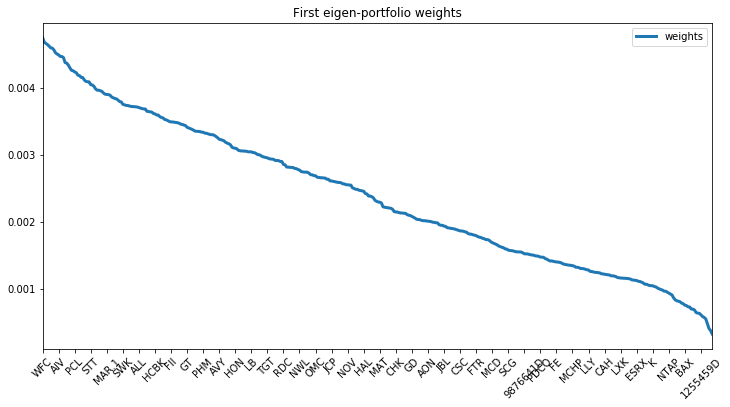

In [0]:
# getting the principal components of fitted pca model

pcs = pca.components_
normalized_pcs = list()

# normalized to put in the form of portfolio weights
for eigen_vector in pcs:
    # scaling  values to sum to 1 
    normalized_values = eigen_vector / eigen_vector.sum()
    normalized_pcs.append(normalized_values)

    
pc_w = normalized_pcs[0]

eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()}, index = stock_tickers)
eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
eigen_prtf1.plot(title='First eigen-portfolio weights', 
                 figsize=(12,6), 
                 xticks=range(0, len(stock_tickers),10), 
                 rot=45, 
                     linewidth=3)

Sum of weights of second eigen-portfolio: 1.00


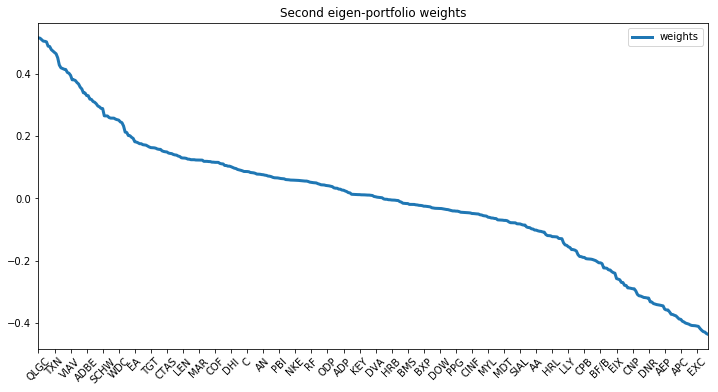

In [0]:
# Computing weights for second eigenportfolio
pc_w_2 = normalized_pcs[1]
eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w_2.squeeze()}, index = stock_tickers)


eigen_prtf2.sort_values(by=['weights'], ascending=False, inplace=True)
print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
eigen_prtf2.plot(title='Second eigen-portfolio weights',
                 figsize=(12,6), 
                 xticks=range(0, len(stock_tickers),10), 
                 rot=45, 
                 linewidth=3)

## Part 4 (Evaluating the performance of eigen portfolios using sharpe ratio)


In the part, we shall backtest our eigenweighted portfolio with our out-of-sample testing dataset. An appropriate evaluation metric will be chosen, in this case sharpe ratio, and compared with the other eigen portfolios. The portfolio with the highest sharpe ratio will be chosen as the final model for our PCA strategy

In [0]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.
    
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)

    annualized_sharpe = annualized_return / annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe

We compute the annualized return of the first portfolio and graph it out against benchmark

First eigen-portfolio:
Return = 18.33%
Volatility = 14.36%
Sharpe = 1.28


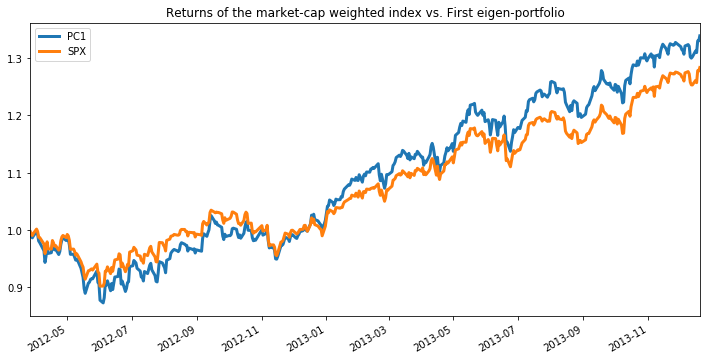

In [0]:
# We compute the annualized return of the first portfolio and graph it out against benchmark
if df_raw_test is not None:
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

In [0]:
df_raw_test.loc[:, eigen_prtf1.index]

,WFC,SPG,VNO,KIM,BXP,BAC,BBT,HST,EQR,STI,...,QLGC,BDX,1255459D,ABC,LH,AMGN,PCG,BIIB,CELG,GILD
2012-03-27,-0.011341,0.000552,-0.000239,0.004115,-0.003254,-0.033233,-0.010821,-0.007798,-0.002461,-0.004167,...,-0.003335,0.001159,-0.003067,-0.003030,-0.003156,0.004295,0.002752,0.003417,-0.005860,0.003600
2012-03-28,0.013824,-0.002353,-0.006658,-0.002049,0.001824,0.015625,0.025740,-0.022370,-0.000164,0.016318,...,-0.002789,-0.002829,-0.004718,-0.010132,-0.005021,-0.001917,-0.019671,-0.004283,-0.001333,-0.000211
2012-03-29,-0.015376,0.003118,-0.001197,-0.010267,-0.004505,-0.022564,-0.012861,-0.009276,0.008719,-0.005764,...,-0.001119,-0.005674,0.001443,0.003071,0.002414,-0.005319,0.003033,0.006288,-0.005338,0.008231
2012-03-30,0.005893,0.006562,0.008988,-0.001037,0.010880,0.004197,-0.002542,0.024969,0.021200,0.000828,...,-0.005599,0.007134,0.004733,0.011735,0.001861,0.009655,0.009770,-0.003794,0.000000,0.022818
2012-04-02,0.010838,0.008651,0.004394,-0.001558,0.002095,0.011494,-0.001593,0.007308,-0.000798,0.004551,...,0.001689,0.003348,0.001844,-0.011851,0.016605,0.002060,0.001843,0.012933,0.008772,-0.001637
2012-04-03,-0.000869,-0.002316,-0.004966,-0.008840,-0.003422,-0.019628,0.011168,0.009069,-0.003836,0.007825,...,-0.007870,0.002824,-0.004703,-0.013014,0.012573,-0.002643,-0.006898,0.009170,0.026726,-0.013940
2012-04-04,-0.017401,-0.006406,-0.015568,-0.018363,-0.011826,-0.030558,-0.010098,-0.026363,-0.009947,-0.018390,...,-0.008499,-0.004736,-0.024035,-0.005171,-0.011037,-0.001178,0.002084,-0.007611,-0.013327,-0.018919
2012-04-05,-0.004427,0.000891,-0.010139,-0.017103,-0.008204,0.003261,-0.002231,-0.003077,-0.005186,0.001665,...,-0.022286,-0.001415,0.002736,-0.006757,0.000537,0.002506,-0.009242,0.006260,0.005428,0.012079
2012-04-09,-0.009191,-0.007820,-0.013171,-0.010332,-0.013332,-0.032503,-0.021406,-0.018519,-0.012869,-0.032419,...,-0.016949,-0.012363,-0.014694,0.005756,-0.034856,-0.014702,-0.007696,-0.015624,-0.005022,-0.024497
2012-04-10,-0.014961,-0.020183,-0.019649,-0.022527,-0.023276,-0.043673,-0.021874,-0.020755,-0.021782,-0.018900,...,-0.033294,-0.008867,-0.023008,-0.001301,-0.009223,-0.012384,-0.011986,-0.012562,-0.000631,-0.017600


We compute the annualized return of the second portfolio and graph it out against benchmark

Second eigen-portfolio:
Return = 1.05%
Volatility = 2.93%
Sharpe = 0.36


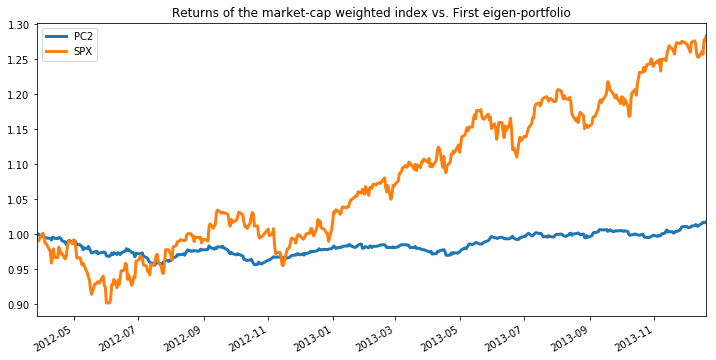

In [0]:
if df_raw_test is not None:
    eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    
df_plot = pd.DataFrame({'PC2': eigen_prtf2_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

In [0]:
pcs.shape

(418, 418)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


Eigen portfolio #5 with the highest Sharpe. Return 66.32%, vol = 24.36%, Sharpe = 2.72


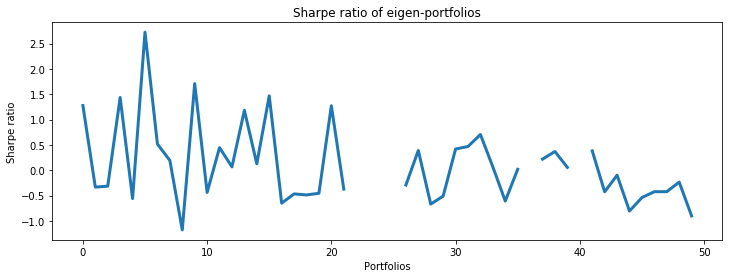

In [0]:
n_portfolios = 50
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)
idx_highest_sharpe = 0 # index into sharpe_metric which identifies a portfolio with the highest Sharpe ratio
    
if pca is not None:
    for ix in range(n_portfolios):
        
        pc_w = pcs[ix,:] / np.sum(pcs[ix,:])
        
        eigen_prtf = pd.DataFrame(data ={'weights': pc_w}, index = stock_tickers)
        
        eigen_returns = np.dot(df_raw_test.loc[:, eigen_prtf.index], eigen_prtf )
        eigen_returns = pd.Series(eigen_returns.squeeze(), index=df_test.index)
        
        annualized_ret[ix], annualized_vol[ix], sharpe_metric[ix] = sharpe_ratio( eigen_returns )
        
    
    sharpe = sharpe_metric[~np.isnan(sharpe_metric)]
    max_sharpe = np.amax(sharpe)
    index_max_sharpe = np.where(sharpe_metric == max_sharpe)
    idx_highest_sharpe = index_max_sharpe[0]
    # idx_highest_sharpe = np.nanargmax(sharpe_metric)
    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (idx_highest_sharpe,
           annualized_ret[idx_highest_sharpe]*100, 
           annualized_vol[idx_highest_sharpe]*100, 
           sharpe_metric[idx_highest_sharpe]))

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

In [0]:
results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)

results.dropna(inplace=True)
results.head(10)
results.shape

(45, 3)

Table of varous portfolio backtested 

In [0]:
results

,Return,Vol,Sharpe
5,0.663208,0.243585,2.722700
9,0.678727,0.397067,1.709350
15,0.898494,0.611863,1.468457
3,0.152469,0.106186,1.435876
0,0.183326,0.143619,1.276477
20,0.392521,0.308450,1.272560
13,0.389422,0.329484,1.181915
32,0.409229,0.579829,0.705775
6,0.176557,0.341316,0.517282
31,0.287097,0.612238,0.468930


Best eigen-portfolio:
Return = 66.32%
Volatility = 24.36%
Sharpe = 2.72


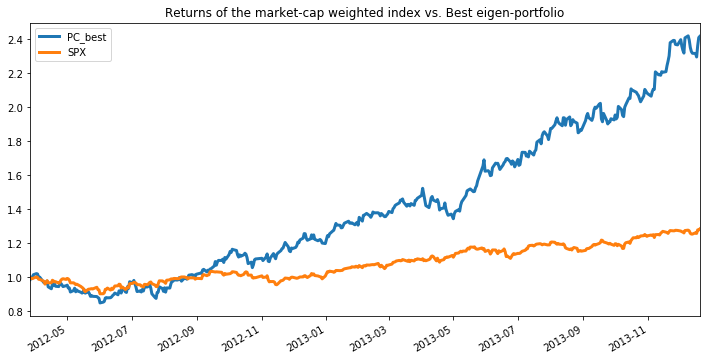

In [0]:

# We compute the annualized return of the best portfolio and graph it out against benchmark
pc_w = normalized_pcs[idx_highest_sharpe[0]]
eigen_prtf_best = pd.DataFrame(data ={'weights': pc_w.squeeze()}, index = stock_tickers)

eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf_best.index], eigen_prtf_best)
eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
print('Best eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

df_plot = pd.DataFrame({'PC_best': eigen_prtf1_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. Best eigen-portfolio', 
                         figsize=(12,6), linewidth=3)

Sum of weights of best eigen-portfolio: 1.00


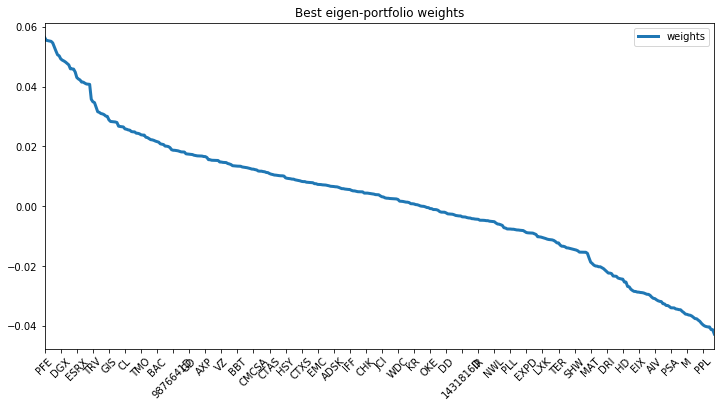

In [0]:
eigen_prtf_best.sort_values(by=['weights'], ascending=False, inplace=True)
print('Sum of weights of best eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
eigen_prtf_best.plot(title='Best eigen-portfolio weights',
                 figsize=(12,6), 
                 xticks=range(0, len(stock_tickers),10), 
                 rot=45, 
                 linewidth=3)